<a href="https://colab.research.google.com/github/ShabariShetty14/DevOps/blob/main/deeplearning_shabari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim
from gensim.models import Word2Vec
print("Gensim imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.5 MB/s eta 0:00:00
Gensim imported successfully!


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('gutenberg')

from nltk.corpus import gutenberg, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [ ]:
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score
)
from sklearn.decomposition import PCA


In [ ]:
macbeth_text = gutenberg.raw("shakespeare-macbeth.txt")
print(macbeth_text[:500])


[The Tragedie of Macbeth by William Shakespeare 1603]


Actus Primus. Scoena Prima.

Thunder and Lightning. Enter three Witches.

  1. When shall we three meet againe?
In Thunder, Lightning, or in Raine?
  2. When the Hurley-burley's done,
When the Battaile's lost, and wonne

   3. That will be ere the set of Sunne

   1. Where the place?
  2. Vpon the Heath

   3. There to meet with Macbeth

   1. I come, Gray-Malkin

   All. Padock calls anon: faire is foule, and foule is faire,
Houer through 


In [ ]:
top_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# RAW
tokens_raw = word_tokenize(macbeth_text)

# CLEAN (lower + remove stopwords + remove non-alpha)
tokens_clean = [
    w.lower() for w in tokens_raw
    if w.isalpha() and w.lower() not in top_words
]

# STEMMED (lower + remove stopwords + remove non-alpha + stemming)
tokens_stemmed = [
    stemmer.stem(w.lower())
    for w in tokens_raw
    if w.isalpha() and w.lower() not in top_words
]

print("RAW sample:", tokens_raw[:10])
print("CLEAN sample:", tokens_clean[:10])
print("STEMMED sample:", tokens_stemmed[:10])

RAW sample: ['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']']
CLEAN sample: ['tragedie', 'macbeth', 'william', 'shakespeare', 'actus', 'primus', 'scoena', 'prima', 'thunder', 'lightning']
STEMMED sample: ['tragedi', 'macbeth', 'william', 'shakespear', 'actu', 'primu', 'scoena', 'prima', 'thunder', 'lightn']


In [ ]:
model_raw = Word2Vec([tokens_raw], vector_size=100, window=5, min_count=1)
model_clean = Word2Vec([tokens_clean], vector_size=100, window=5, min_count=1)
model_stemmed = Word2Vec([tokens_stemmed], vector_size=100, window=5, min_count=1)

print("All 3 models trained!")


All 3 models trained!


In [ ]:
sentences = [s for s in macbeth_text.split("\n") if len(s.strip()) > 10]

def sentence_to_vec(sentence, model):
    words = [w.lower() for w in word_tokenize(sentence) if w.isalpha()]
    words = [w for w in words if w in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

X_raw = np.array([sentence_to_vec(s, model_raw) for s in sentences])
X_clean = np.array([sentence_to_vec(s, model_clean) for s in sentences])
X_stemmed = np.array([sentence_to_vec(s, model_stemmed) for s in sentences])

print(X_raw.shape, X_clean.shape, X_stemmed.shape)


(2519, 100) (2519, 100) (2519, 100)


In [ ]:
y = np.array([1 if "king" in s.lower() else 0 for s in sentences])
print("Label distribution:", np.bincount(y))

Label distribution: [2424   95]


In [ ]:
def train_and_get_scores(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)[:,1]
    return accuracy_score(y_test, pred), roc_auc_score(y_test, prob)

acc_raw, auc_raw = train_and_get_scores(X_raw, y)
acc_clean, auc_clean = train_and_get_scores(X_clean, y)
acc_stemmed, auc_stemmed = train_and_get_scores(X_stemmed, y)

In [ ]:
results = pd.DataFrame({
    "Model": ["Raw", "Clean", "Stemmed"],
    "Accuracy": [acc_raw, acc_clean, acc_stemmed],
    "ROC-AUC": [auc_raw, auc_clean, auc_stemmed]
})
results

,Model,Accuracy,ROC-AUC
0,Raw,0.956349,0.535317
1,Clean,0.956349,0.531309
2,Stemmed,0.956349,0.626462


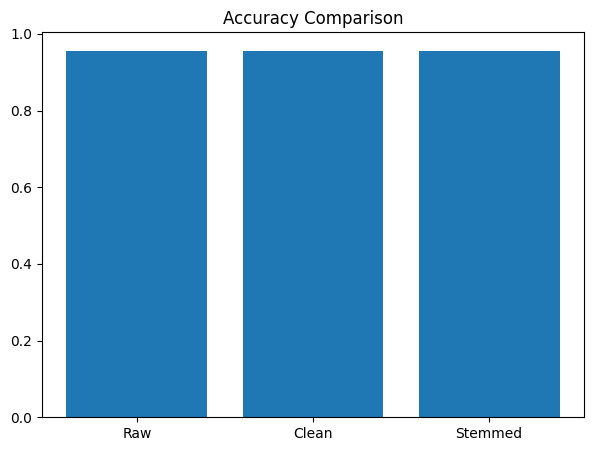

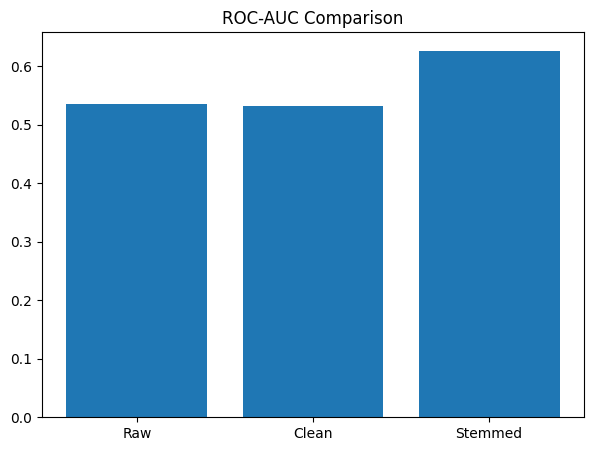

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(["Raw","Clean","Stemmed"], [acc_raw, acc_clean, acc_stemmed])
plt.title("Accuracy Comparison")
plt.show()

plt.figure(figsize=(7,5))
plt.bar(["Raw","Clean","Stemmed"], [auc_raw, auc_clean, auc_stemmed])
plt.title("ROC-AUC Comparison")
plt.show()

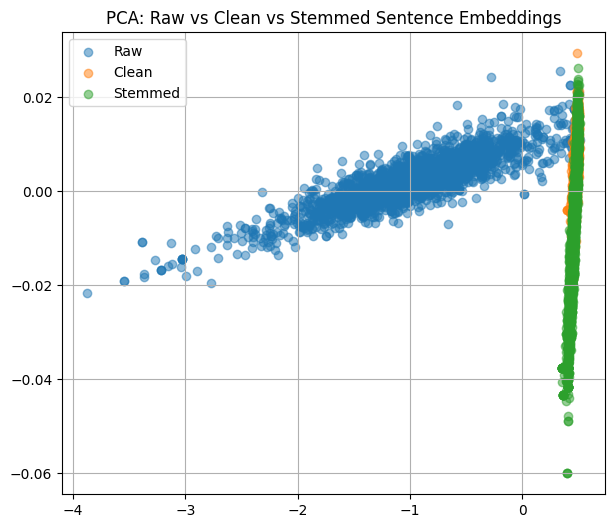

In [ ]:
pca = PCA(n_components=2)
X_comb = np.vstack([X_raw, X_clean, X_stemmed])
X_pca = pca.fit_transform(X_comb)

n = len(X_raw)
m = len(X_clean)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:n,0], X_pca[:n,1], label="Raw", alpha=0.5)
plt.scatter(X_pca[n:n+m,0], X_pca[n:n+m,1], label="Clean", alpha=0.5)
plt.scatter(X_pca[n+m:,0], X_pca[n+m:,1], label="Stemmed", alpha=0.5)

plt.legend()
plt.title("PCA: Raw vs Clean vs Stemmed Sentence Embeddings")
plt.grid(True)
plt.show()

In [ ]:
print("\n===== FINAL SUMMARY =====")

print(results)

best_accuracy = results.iloc[results['Accuracy'].idxmax()]
best_auc = results.iloc[results['ROC-AUC'].idxmax()]

print("\nBest Accuracy Model:", best_accuracy['Model'], "=", best_accuracy['Accuracy'])
print("Best ROC-AUC Model:", best_auc['Model'], "=", best_auc['ROC-AUC'])


===== FINAL SUMMARY =====
     Model  Accuracy   ROC-AUC
0      Raw  0.956349  0.535317
1    Clean  0.956349  0.531309
2  Stemmed  0.956349  0.626462

Best Accuracy Model: Raw = 0.9563492063492064
Best ROC-AUC Model: Stemmed = 0.6264617125612976
